In [1]:
import requests
import time

def download(method, url, params=None, data=None, headers=None, timeout=1, retries=4):
    if headers == None:
        headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36"}
    
    try:
        resp = requests.request(method, url, 
                                params=params, data=data, 
                                headers=headers, timeout=timeout)
        resp.raise_for_status()
        
    except requests.exceptions.HTTPError as e:
        if 500 <= e.response.status_code < 600 and retries > 0:
            print("remained retry:", retries)
            time.sleep(timeout)
            resp = download(method, url, params, data, headers, timeout, retries-1) 
        else:
            print(resp.status_code)
            print(resp.reason)
        
    return resp

In [2]:
from bs4 import BeautifulSoup

# AJAX
- 에이젝스 또는 와작스 라고 읽음

In [35]:
# 여태까지 해왔던 방법으로 아래 테스트 사이트에서 검색 결과 이미지를 가져와보자.

url = "http://example.webscraping.com/places/default/search"

In [36]:
html = download('get', url)

In [37]:
dom = BeautifulSoup(html.text, 'lxml')

In [40]:
# 이미지가 없다?

dom.select("div#results a")

[]

In [9]:
# 소스코드를 뜯어보자.

html.text

'<!--[if HTML5]><![endif]-->\n<!DOCTYPE html>\n<!-- paulirish.com/2008/conditional-stylesheets-vs-css-hacks-answer-neither/ -->\n<!--[if lt IE 7]><html class="ie ie6 ie-lte9 ie-lte8 ie-lte7 no-js" lang="en-us"> <![endif]-->\n<!--[if IE 7]><html class="ie ie7 ie-lte9 ie-lte8 ie-lte7 no-js" lang="en-us"> <![endif]-->\n<!--[if IE 8]><html class="ie ie8 ie-lte9 ie-lte8 no-js" lang="en-us"> <![endif]-->\n<!--[if IE 9]><html class="ie9 ie-lte9 no-js" lang="en-us"> <![endif]-->\n<!--[if (gt IE 9)|!(IE)]><!--> <html class="no-js" lang="en-us"> <!--<![endif]-->\n<head>\n<title>Example web scraping website</title>\n  <!--[if !HTML5]>\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n  <![endif]-->\n  <!-- www.phpied.com/conditional-comments-block-downloads/ -->\n  <!-- Always force latest IE rendering engine\n       (even in intranet) & Chrome Frame\n       Remove this if you use the .htaccess -->\n\t   \n  <meta charset="utf-8" />\n\n  <!-- http://dev.w3.org/html5/markup/me

---

### 개발자도구 > 네트워크 탭을 켜놓은 상태에서 search 버튼 눌러보기
- search.json? 어쩌구 하는 파일과 이미지 파일들이 추가로 생성되는 것을 볼 수 있다.
- 페이지 새로고침하면 html부터 모든 파일을 새로 받아오는 반면, 검색할때는 기존 html 파일에 추가로 파일만 받아온다.
- 우리가 필요한 정보는 저 새로 생긴 파일이 갖고 있다.
- 저 파일의 headers 를 보면 저 파일 받기 위해 필요한 파라미터를 알 수 있다.

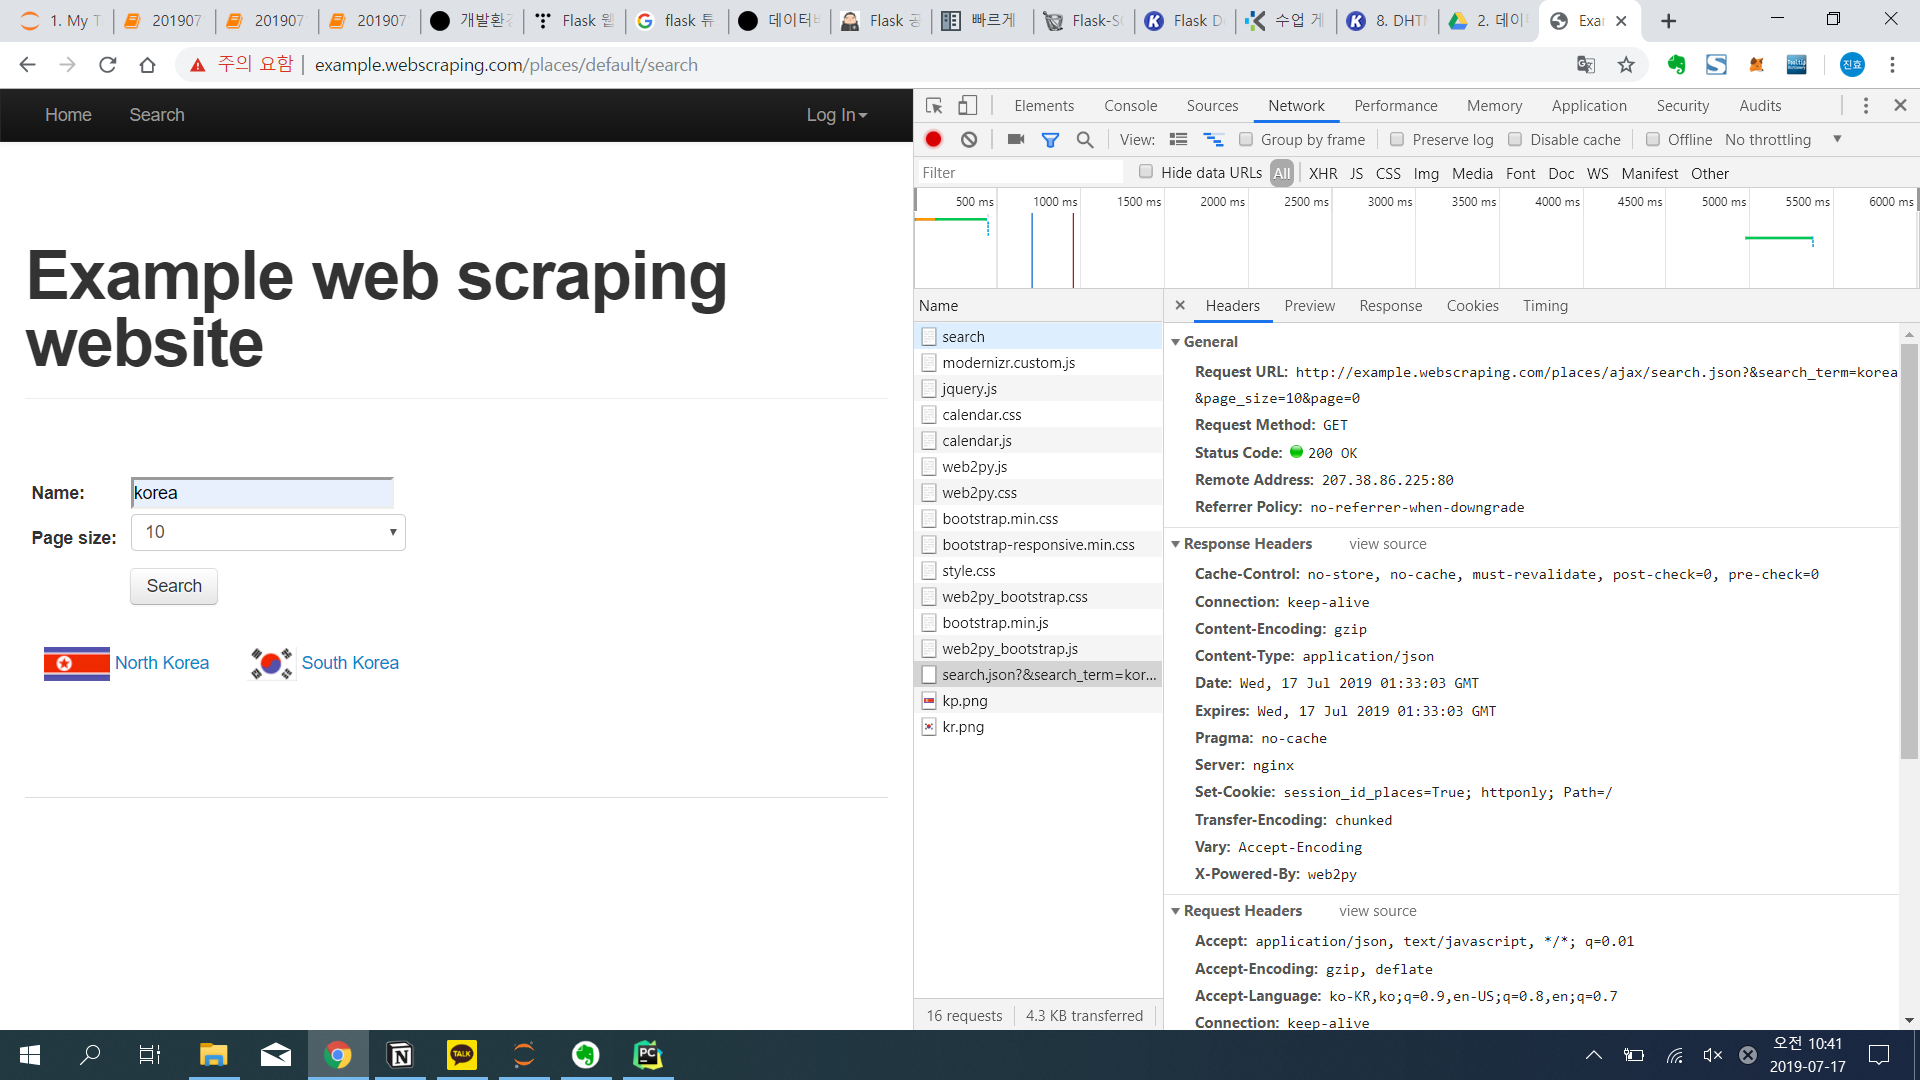

In [13]:
url = "http://example.webscraping.com/places/ajax/search.json?&search_term=korea&page_size=10&page=0"

In [14]:
url_parsed = requests.compat.urlparse(url)
url_parsed

ParseResult(scheme='http', netloc='example.webscraping.com', path='/places/ajax/search.json', params='', query='&search_term=korea&page_size=10&page=0', fragment='')

In [23]:
url = url_parsed[0] + "://" + url_parsed[1] + url_parsed[2]
url

'http://example.webscraping.com/places/ajax/search.json'

In [24]:
params = {
    'search_term':"korea",
    'page_size':10,
    'page':0
}

In [25]:
html = download('get', url, params)
dom = BeautifulSoup(html.text, 'lxml')

In [26]:
# 생긴걸 보아하니 json파일 같다.

html.text

'{"records": [{"pretty_link": "<div><a href=\\"/places/default/view/North-Korea-165\\"><img src=\\"/places/static/images/flags/kp.png\\" /> North Korea</a></div>", "country": "North Korea", "id": 4552797}, {"pretty_link": "<div><a href=\\"/places/default/view/South-Korea-211\\"><img src=\\"/places/static/images/flags/kr.png\\" /> South Korea</a></div>", "country": "South Korea", "id": 4552843}], "num_pages": 1, "error": ""}\n'

In [28]:
# .json()으로 json 파일을 불러들일 수 있다.
# dictionary type.

html.json()

{'records': [{'pretty_link': '<div><a href="/places/default/view/North-Korea-165"><img src="/places/static/images/flags/kp.png" /> North Korea</a></div>',
   'country': 'North Korea',
   'id': 4552797},
  {'pretty_link': '<div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png" /> South Korea</a></div>',
   'country': 'South Korea',
   'id': 4552843}],
 'num_pages': 1,
 'error': ''}

In [31]:
html.json()["records"]

[{'pretty_link': '<div><a href="/places/default/view/North-Korea-165"><img src="/places/static/images/flags/kp.png" /> North Korea</a></div>',
  'country': 'North Korea',
  'id': 4552797},
 {'pretty_link': '<div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png" /> South Korea</a></div>',
  'country': 'South Korea',
  'id': 4552843}]

In [33]:
for _ in html.json()["records"]:
    print(_["country"])

North Korea
South Korea


---

# Selenium
- 사전 준비
    - http://chromedriver.chromium.org/downloads 에서 자기 chrome 버전에 맞는 파일 다운로드
    - 압축을 풀고 chromedriver.exe 파일을 실행시키지 말고, 현재 작업중인 경로에 넣어준다.

In [41]:
!pip install selenium

In [42]:
from selenium import webdriver

In [46]:
# 실행시키면 새로운 크롬 브라우저가 새창이 하나 생긴다.
# "Chrome이 자동화된 테스트 소프트웨어에 의해 제어되고 있습니다." 라고 보이면 제대로 된 것이다.

driver = webdriver.Chrome()

In [45]:
# 종료할때는 close.
# 그냥 창을 끄지 말고 이렇게 끄는 것을 권장함.

# driver.close()

In [48]:
# 네이버 아이디 패스워드를 저장해서 로그인할때 써보자
# json 파일은 반드시 쌍따옴표만 써야한다!

%%writefile account.json
{
    "id":"자기 아이디",
    "pw":"자기 비밀번호"
}

Writing account.json


In [51]:
import json

# json파일을 불러와보자

with open("account.json") as fp:
    account = json.load(fp)

In [52]:
# id가 정상적으로 나오는지 확인!

account['id']

'wlsgy93'

In [53]:
# 자동화된 크롬창이 네이버로 이동했는지 확인
# 코드 레벨에서 브라우저를 조종한다.

driver.get("http://www.naver.com")

In [59]:
# 연습할 사이트로 이동

driver.get(url)

In [65]:
# 현재 웹페이지의 소스를 보여주는 메서드

driver.page_source

'<html class=" js flexbox flexboxlegacy canvas canvastext webgl no-touch geolocation postmessage websqldatabase indexeddb hashchange history draganddrop websockets rgba hsla multiplebgs backgroundsize borderimage borderradius boxshadow textshadow opacity cssanimations csscolumns cssgradients cssreflections csstransforms csstransforms3d csstransitions fontface generatedcontent video audio localstorage sessionstorage webworkers no-applicationcache svg inlinesvg smil svgclippaths" lang="en-us" style=""><!--<![endif]--><head>\n<title>Example web scraping website</title>\n  <!--[if !HTML5]>\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n  <![endif]-->\n  <!-- www.phpied.com/conditional-comments-block-downloads/ -->\n  <!-- Always force latest IE rendering engine\n       (even in intranet) & Chrome Frame\n       Remove this if you use the .htaccess -->\n\t   \n  <meta charset="utf-8">\n\n  <!-- http://dev.w3.org/html5/markup/meta.name.html -->\n  <meta name="applicati

In [62]:
# 검색창을 선택하기
# 실행시킨 후에 자동화 크롬창에 검색창에 커서가 깜빡이는 것을 확인.

inputTag = driver.find_element_by_id("search_term")
inputTag

<selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.43669792321647627-1")>

In [63]:
# send_keys는 말그대로 key를 보냄
# 실행시킨 후에 자동화 크롬창에 가면 검생창에 korea가 입력되어 잇는 것을 확인

inputTag.send_keys("korea")

In [64]:
# 검색 버튼을 찾음.

driver.find_element_by_xpath("//input[@type='submit']")

<selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.43669792321647627-2")>

In [66]:
# click 메서드로 검색버튼을 실행시킨다.

driver.find_element_by_xpath("//input[@type='submit']").click()

In [67]:
# BeautifulSoup의 도움이 필요할 것인가?

dom = BeautifulSoup(driver.page_source, 'lxml')

In [68]:
# 이번에는 css selector로 잘 가져 왔다!
# 브라우저가 렌더링한 후의 html을 받아왔기 떄문에 된다.
# 이전에 했던 방법은 브라우저가 렌더링하지 않은 소스를 받아와서 안보이는 것이었다.

dom.select("#results")

[<div id="results"><table><tbody><tr><td><div><a href="/places/default/view/North-Korea-165"><img src="/places/static/images/flags/kp.png"/> North Korea</a></div></td><td><div><a href="/places/default/view/South-Korea-211"><img src="/places/static/images/flags/kr.png"/> South Korea</a></div></td></tr></tbody></table></div>]

In [69]:
# selenium에서도 css selector가 잘 작동을 한다.
# dom에서 쓴 방식과 똑같이 할 수 있음.

driver.find_element_by_css_selector("#results").text

'North Korea\nSouth Korea'

---

### 네이버에서 로그인해보기

In [71]:
driver.get("https://www.naver.com")

In [73]:
driver.find_element_by_css_selector(".section_login").click()

In [76]:
inputTag = driver.find_element_by_id('id')
inputTag

<selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.7919780825733553-1")>

In [77]:
inputTag.send_keys(account["id"])

In [78]:
inputTag = driver.find_element_by_id('pw').send_keys(account["pw"])

In [82]:
# 자동입력 방지 어쩌구로 로그인이 안된다. -> 마우스 움직임이 없으면 감지해서 자동 로그인을 검출하는 시스템이 네이버에 있음.
# 뚫는 방법 없다... 수동으로 로그인 해주자;
# 혹시나 된다면?  ->  본인의 네이버 로그인 보안 설정이 아주 낮게 되어있는 것이다.

driver.find_element_by_css_selector("input[type=submit]").click()

In [83]:
driver.get("https://www.naver.com")

In [87]:
# 네이버 메일 클리하기
# 소스에서 class=an_a mn_mail 이라고 되어 있는데, 띄어쓰기는 다중 상속이다.
# 그러나 css selector에서는 띄어쓰는 자식을 찾는다는 뜻이다.
# .an_a.mn_mail 처럼 .으로 이어주면 다중상속이라는 의미이니 바꿔준다.

driver.find_element_by_css_selector(".an_a.mn_mail").click()

In [88]:
# 로그인창 뜨면 수동 로그인하자

In [95]:
# 모든 메일 제목 가져오기

driver.find_elements_by_css_selector(".mail_title")

[<selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-1")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-2")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-3")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-4")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-5")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-6")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.9610747999104736-7")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", el

In [100]:
# for문으로 제목을 뽑아보자.

for _ in driver.find_elements_by_css_selector(".mail_title"):
    print(_.text)

새로운 환경에서 로그인 되었습니다.
This Week in the FCFL 7/16/19
【DOMINISTORE】この夏の思い出作りは、最寄り(？)の“wonderland”で♪
1 days left! 750,000 IOTX to Give Away! KuCoin x BitUniverse — IoTeX (IOTX) International Grid Trading Competition
KuCoin Weekly News and Promotions
연결된 Google 계정 관련 보안 알림
[KOTRA/SLI][바우처] 중국 시장진출 실무 과정(8.22)
[ICT CoC] 시설 및 장비 이용과 수요에 대한 설문 조사
[무료] [KOTRA]업종별 FTA 활용 실무- 기계 참가 교육생 모집(7.24 ~7.26)
[CGV] 신진효님께서 예매한 내역이 취소 되었습니다.
[CGV] 신진효님께서 예매한 내역입니다.
[데이터진흥원] 데이터 자격시험 응시 최종 확인
[CGV] 신진효님께서 예매한 내역입니다.
One helluva day!
[ICT CoC] 시설 및 장비 이용과 수요에 대한 설문 조사
[리마인더] [KOTRA] 프리미엄해외시장조사 설문(7.11限)(경품 제공)
Quarter in review: Q2 2019
새로운 환경에서 로그인 되었습니다.
[이벤트] 현직 New York KPMG 데이터사이언티스트 우정훈님에게 무엇이든 물어보세요!
[ 공공데이터포털 ] 회원가입을 위한 이메일 인증번호
[DBGuide.net] 마이데이터 아이디어 발표회에 여러분을 초대합니다.(7/11)
RE: 마케팅 고액연봉 채용관련 정보입니다. (AD)
[DBGuide.net] (2019 데이터 품질대상) 대한민국 최고의 데이터 품질 관리 기관·기업을 찾습니다!
[2019년 6월 소식] 국민대학교 뉴스레터
[데이터진흥원_빅데이터_청년인재_고려대학교_과정] 비밀번호 변경
[KOTRA] 프리미엄해외시장조사 설문(경품 제공)
Facebook’s new Libra currency sets Bitcoin on fi

In [99]:
# xpath로 하는 방법 (다른 방법)
# //는 자손(손자까지), /는 자식(아들까지)

for _ in driver.find_elements_by_xpath("//div[@class='mTitle']//span/strong"):
    print(_.text) 

새로운 환경에서 로그인 되었습니다.
This Week in the FCFL 7/16/19
【DOMINISTORE】この夏の思い出作りは、最寄り(？)の“wonderland”で♪
1 days left! 750,000 IOTX to Give Away! KuCoin x BitUniverse — IoTeX (IOTX) International Grid Trading Competition
KuCoin Weekly News and Promotions
연결된 Google 계정 관련 보안 알림
[KOTRA/SLI][바우처] 중국 시장진출 실무 과정(8.22)
[ICT CoC] 시설 및 장비 이용과 수요에 대한 설문 조사
[무료] [KOTRA]업종별 FTA 활용 실무- 기계 참가 교육생 모집(7.24 ~7.26)
[CGV] 신진효님께서 예매한 내역이 취소 되었습니다.
[CGV] 신진효님께서 예매한 내역입니다.
[데이터진흥원] 데이터 자격시험 응시 최종 확인
[CGV] 신진효님께서 예매한 내역입니다.
One helluva day!
[ICT CoC] 시설 및 장비 이용과 수요에 대한 설문 조사
[리마인더] [KOTRA] 프리미엄해외시장조사 설문(7.11限)(경품 제공)
Quarter in review: Q2 2019
새로운 환경에서 로그인 되었습니다.
[이벤트] 현직 New York KPMG 데이터사이언티스트 우정훈님에게 무엇이든 물어보세요!
[ 공공데이터포털 ] 회원가입을 위한 이메일 인증번호
[DBGuide.net] 마이데이터 아이디어 발표회에 여러분을 초대합니다.(7/11)
RE: 마케팅 고액연봉 채용관련 정보입니다. (AD)
[DBGuide.net] (2019 데이터 품질대상) 대한민국 최고의 데이터 품질 관리 기관·기업을 찾습니다!
[2019년 6월 소식] 국민대학교 뉴스레터
[데이터진흥원_빅데이터_청년인재_고려대학교_과정] 비밀번호 변경
[KOTRA] 프리미엄해외시장조사 설문(경품 제공)
Facebook’s new Libra currency sets Bitcoin on fi

### 스팸메일 가져와보세요.

In [107]:
# 스팸메일함으로 이동

driver.find_element_by_css_selector(".item_wrap.bu6").click()

In [108]:
# 똑같이.

for _ in driver.find_elements_by_css_selector(".mail_title"):
    print(_.text)

good
Flash Alert #3: 22.8 times better than Netflix
Flash Alert #2: Institutions piling into Bitcoin
(광고) 창업아이템으로 이런 건 어떠세요?
Flash Alert: Shocking proof of strongest Bitcoin bull in history
You’re missing out !
good
(광고)요즘 가장 핫한 보험은 메리츠 유병자의료실비보험! 나이많고 아파도 저렴하게 가입할 수 있는 7월 새로운 가입조건 및 월 보험료는?
(광고)창업 비용100% 전액(보증금,권리금,인테리어 등 최대2억원) 지원해드립니다.
(광고)선착순!! 휴대폰매장창업 비용100% 전액지원해드립니다.
Click
Last call
hum
Good
Hit


### cookie

In [277]:
driver.get_cookies()

[{'domain': '.naver.com',
  'httpOnly': False,
  'name': 'NIPD',
  'path': '/',
  'secure': False,
  'value': '1'},
 {'domain': '.naver.com',
  'expiry': 2524640400.40484,
  'httpOnly': False,
  'name': 'NNB',
  'path': '/',
  'secure': False,
  'value': 'IEBVWEKXX4XF2'},
 {'domain': '.naver.com',
  'httpOnly': False,
  'name': 'NID_JKL',
  'path': '/',
  'secure': True,
  'value': '2i+BUN0Kgk2WbH53lNPiiXLPrmlX79sC65ryEXezFRc='},
 {'domain': '.naver.com',
  'httpOnly': False,
  'name': 'nid_inf',
  'path': '/',
  'secure': False,
  'value': '1343077727'},
 {'domain': '.naver.com',
  'httpOnly': False,
  'name': 'NID_SES',
  'path': '/',
  'secure': False,
  'value': 'AAABqEuBJzf8XVETo2fksOycHOL78Vt+7GyIQXOocHHlR+2l3wQciFopa+0aaHDy3/HsVQJ+TKHC9jPoJlef1gNig4RV3jj8EOORyv8Dw3u7fghloB0ke+sl83JwgLxkRDVAjxJ12/kcx/mWsIIQa4HE6ZgRqeYpLmxdJiVhzjR4xqN5PIIxDmpW1jaBtCeQ02JJY0eDeq95RIjVo41O7tucOJxw7jPkRRbb73BedSvcLX3DXAs+dtCrWUr1TDPRIPttWmaIv1MVVPhwq/6mZAVnUGhir6C4kTSAQrfpxrjr6sjVUG5NaXrCr6l6VtQL5TIi

In [278]:
for cookie in driver.get_cookies():
    print(cookie["name"], cookie["value"])

NIPD 1
NNB IEBVWEKXX4XF2
NID_JKL 2i+BUN0Kgk2WbH53lNPiiXLPrmlX79sC65ryEXezFRc=
nid_inf 1343077727
NID_SES AAABqEuBJzf8XVETo2fksOycHOL78Vt+7GyIQXOocHHlR+2l3wQciFopa+0aaHDy3/HsVQJ+TKHC9jPoJlef1gNig4RV3jj8EOORyv8Dw3u7fghloB0ke+sl83JwgLxkRDVAjxJ12/kcx/mWsIIQa4HE6ZgRqeYpLmxdJiVhzjR4xqN5PIIxDmpW1jaBtCeQ02JJY0eDeq95RIjVo41O7tucOJxw7jPkRRbb73BedSvcLX3DXAs+dtCrWUr1TDPRIPttWmaIv1MVVPhwq/6mZAVnUGhir6C4kTSAQrfpxrjr6sjVUG5NaXrCr6l6VtQL5TIi0PCQ5skKZFTK+mkP4UfGnA3eItqsFQFDEAz2C9lW0NzEu24tXxA0BHqOQd7p8BIOJbrlDPgh1rHuyF51wGNriL2j6SssBSB08yLbO/3p971U60qLdlVpyIWv8Uq5f9zk+7TWkdJxbcQDwd5WSSBrsz6IzqiSyHJ/aafuvIFt9MGF4e+yPJkxN72h9gBdEYdju6L92zVl8dtqDdcPDNiie6DrO+1b0b2YvV+NVA3PiLn1HdhMgLZB6FKHAze6em5nrg==
NID_AUT +Euog3ghc4YY/A0uBUIqDwkgXIy59i81IrG6Unmkvbij3GgOF+gMofUx0sBZCxIB
NMUSER YXYmFAEwaqbsFxKlaxEZ+rwqpXvlKqnwFxMqKqt/KxblaqEwKogsKAnsadEsFAKdKoMqaw/wFxRpad/syqvs6xRpadUs6xnstonsarRTBdRLa9vstonsH405pzk/7xt5W4d5W4JrpBU5MreR7A2lKAgs16lvpB2RFV9qp6FTW43CbNv5W4d5W4JrpBU5MreR7A2lKAgs
page_uid UfJ53wpp6AdsshqgjG4s

In [113]:
import requests

session = requests.Session()

In [114]:
# 이름이 CookieJar이다.. 커여워..ㅎ

session.cookies

<RequestsCookieJar[]>

In [118]:
# 쿠키를 저장해주는 메서드

?session.cookies.set

In [119]:
# for문으로 쿠키를 저장하자

for cookie in driver.get_cookies():
    session.cookies.set(cookie["name"], cookie["value"])

In [120]:
# 쿠키가 저장된 상태에서 스팸메일함의 url을 get해보자.
# 스팸을 검색해서 페이지를 잘 가져왔는지 확인해보자
# 제대로 안 되었으면, 로그인이 필요하다는 문구가 있을 것이다.  ->  쿠키 정보가 없기 때문이다.

html = session.get("https://mail.naver.com/#%7B%22fClass%22%3A%22list%22%2C%22oParameter%22%3A%7B%22page%22%3A1%2C%22sortField%22%3A1%2C%22sortType%22%3A0%2C%22folderSN%22%3A%225%22%2C%22type%22%3A%22%22%2C%22isUnread%22%3Atrue%7D%7D")
html.text

'\n\n\n<!DOCTYPE HTML>\n\n\t\n\t\n\t\n\t\n\t\n\t\t<html lang="ko">\n\t\n\n\n<head>\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\n\t<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\n\t\n\t\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail2_le.min.190611.css">\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_skin.min.190611.css">\n\t\t\t\t\n\t\t\t\t\n\t\t\t\n\t\t\n\t\n\n\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\n\t\t\t\t\t<link rel="dns-prefetch" href="//ssl.pstatic.net" />\n\t\t\t\t\t<link rel="dns-prefetch" href="//lcs.naver.com" />\n\t\t\t\t\t<link rel="dns-prefetch" href="//cc.naver.com" />\n\t\t\t\t\t<link rel="dns-prefetch" href="//static.nid.naver.com" />\n\t\t\t\t\t<link rel="dns-prefetch" href="//phinf.pstatic.net" />\n\t\t\t\t\t<link rel="stylesheet" type="text/css" href="/css/mail_me.min.190611.css">\n\t\t\t\t\n\t\t\t\n\t\t\t<link rel="shortcut icon" href="/favicon.ico?2">\n\t\t\t\n\t\t\n\n\t\

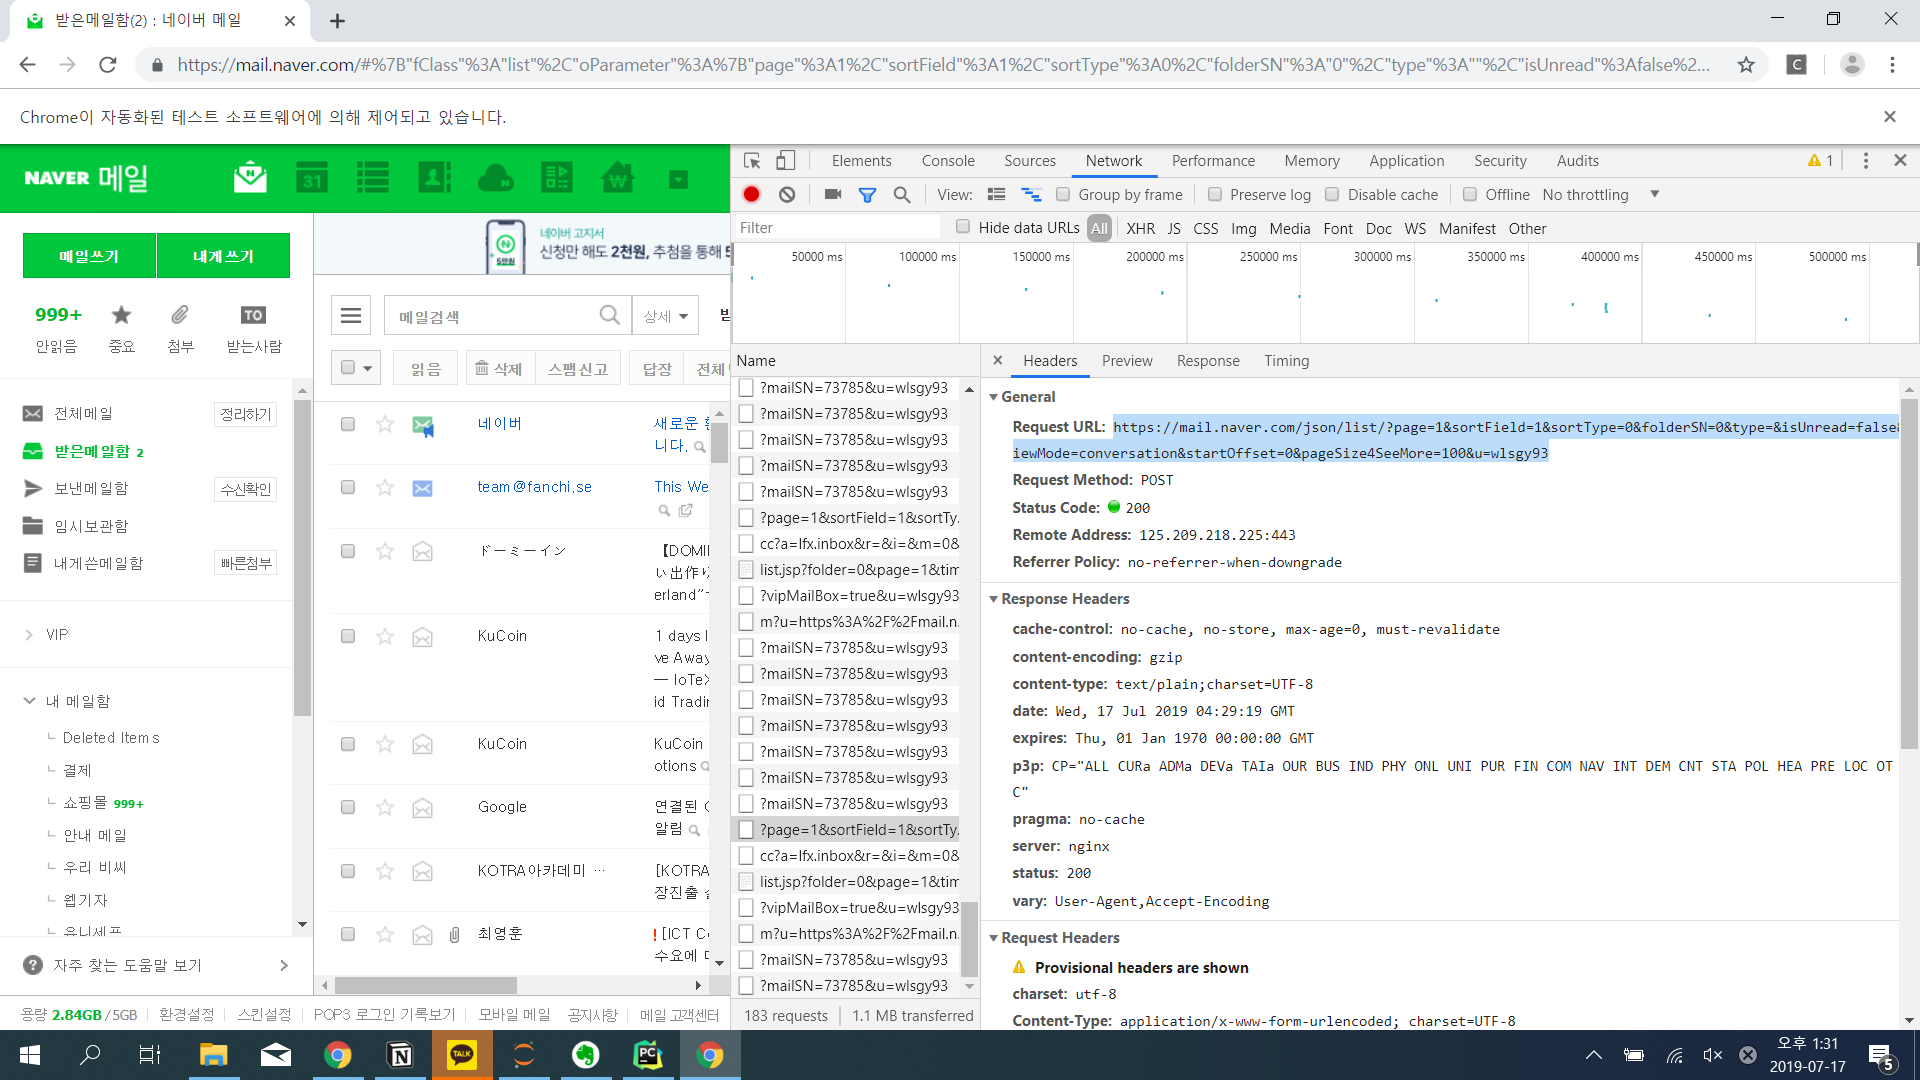

In [129]:
# 받은 메일함으로 다시 갔을때, json 가로채기
# 개발자도구 네트워크 탭을 켜놓은 상태에서 받은 메일함으로 이동해보면 ?page=어쩌구 하는 정보를 받아왔을 것이다.
# preview를 보면 여기에 받은메일함의 메일 정보가 담겨있는 것을 알 수 있따.
# ?page=어쩌구 하는 이 정보의 request 정보를 가로채면 메일에 대한 정보를 얻어올 수 있다. (아니면 xhr 파일을 찾으면 됨)
# url을 직접 요청하기 때문에, selenium이 렌더링 하는 시간이 없어진다. 
# 렌더링하면 오래 걸리므로 selenium은 직접 스크래핑하는게 아니라 이렇게 써야한다.

# post 방식으로 바꿈
html = session.post("https://mail.naver.com/json/list/?page=1&sortField=1&sortType=0&folderSN=0&type=&isUnread=false&viewMode=conversation&startOffset=0&pageSize4SeeMore=100&u=wlsgy93")
html.json()

{'currentTime': 1563337850,
 'lastPage': 23,
 'Message': '',
 'lastOffset': 103,
 'pageSize': 100,
 'unreadCount': 2,
 'mailData': [{'mailSN': 73783,
   'folderSN': 0,
   'folderName': None,
   'iconType': 0,
   'status': 2129920,
   'from': {'name': '네이버', 'email': 'help@help.naver.com'},
   'subject': '새로운 환경에서 로그인 되었습니다.',
   'receivedTime': 1563330963,
   'sentTime': 1563330963,
   'size': 21946,
   'attachCount': 0,
   'iDomainEmail': 'wlsgy93@naver.com',
   'priority': 3,
   'securityLevel': None,
   'reSend': False,
   'color': '#ffffff',
   'preview': '',
   'mimeSN': '1563330963.695594.36415.42752',
   'toList': [{'name': '', 'email': 'wlsgy93@naver.com'}],
   'spamType': None,
   'attachInfo': [],
   'threadId': '<1563330963682.7f32e.7835858@cvowl1011.nm>',
   'bccList': [],
   'receiveByBcc': False,
   'threadCount': 1,
   'unreadThreadCount': 1,
   'firstLocatedTime': 1563330963,
   'remindAt': 0,
   'threadRemindAt': 0,
   'threadRemindFlag': 0,
   'category': 101,
   'las

In [128]:
# 한글이 깨질수도 있으니 unescape해줌.
from html import unescape

# 메일 제목만 뽑아와보자.
html = session.post("https://mail.naver.com/json/list/?page=1&sortField=1&sortType=0&folderSN=0&type=&isUnread=false&viewMode=conversation&startOffset=0&pageSize4SeeMore=100&u=wlsgy93")
for _ in html.json()["mailData"]:
    print(unescape(_['subject']))

새로운 환경에서 로그인 되었습니다.
This Week in the FCFL 7/16/19
【DOMINISTORE】この夏の思い出作りは、最寄り(？)の“wonderland”で♪
1 days left! 750,000 IOTX to Give Away! KuCoin x BitUniverse — IoTeX (IOTX) International Grid Trading Competition
KuCoin Weekly News and Promotions
연결된 Google 계정 관련 보안 알림
[KOTRA/SLI][바우처] 중국 시장진출 실무 과정(8.22)
[ICT CoC] 시설 및 장비 이용과 수요에 대한 설문 조사 
[무료] [KOTRA]업종별 FTA 활용 실무- 기계 참가 교육생 모집(7.24 ~7.26)
[CGV] 신진효님께서 예매한 내역이 취소 되었습니다.
[CGV] 신진효님께서 예매한 내역입니다.
[데이터진흥원] 데이터 자격시험 응시 최종 확인
[CGV] 신진효님께서 예매한 내역입니다.
One helluva day!
[ICT CoC] 시설 및 장비 이용과 수요에 대한 설문 조사
[리마인더] [KOTRA] 프리미엄해외시장조사 설문(7.11限)(경품 제공)
Quarter in review: Q2 2019
새로운 환경에서 로그인 되었습니다.
[이벤트] 현직 New York KPMG 데이터사이언티스트 우정훈님에게 무엇이든 물어보세요!
[ 공공데이터포털 ] 회원가입을 위한 이메일 인증번호
[DBGuide.net] 마이데이터 아이디어 발표회에 여러분을 초대합니다.(7/11)
RE: 마케팅 고액연봉 채용관련 정보입니다. (AD)
[DBGuide.net] (2019 데이터 품질대상) 대한민국 최고의 데이터 품질 관리 기관·기업을 찾습니다!
[2019년 6월 소식] 국민대학교 뉴스레터
[데이터진흥원_빅데이터_청년인재_고려대학교_과정] 비밀번호 변경
[KOTRA] 프리미엄해외시장조사 설문(경품 제공)
Facebook’s new Libra currency sets Bitcoin on f

In [130]:
driver.get("https://cc.naver.com/cc?a=mor.cafe&r=1&i=&bw=1025&px=764&py=223&sx=764&sy=223&m=1&nsc=gnb.v2&u=http%3A%2F%2Fcafe.naver.com%2F")

In [137]:
for i in driver.find_elements_by_css_selector("strong.name"):
    print(i.text)


중고나라
네일동 : 일본여행카페
디지털감성 e북카페
LG노트북 사용자 모임 - 그램 사용자 모임
The Glory Of Genesis
■ 신형 K7 프리미어 동호회 [클럽 K7] 2019 페이스리프트 올뉴
열끼, 눈동자에 드리운 정신의 당찬 기운
2014 국민대 디지털사진찍기
129 국민대학교 학군단 54기
은마서♥은평맘 마포맘 서대문맘 맘카페-은평구 마포구 서대문구
오키나와 달인 카페
과천사랑 장터
이북커, 전자책을 사랑하는 사람들의 모임
웃찾공-웃음을 찾은 공부
국민 명품 아기책 애플비 공식카페
[김영사 공식 카페]
동두천알뜰맘카페-동두천맘 중고,벼룩,공구,직거래장터
1인출판 꿈꾸는 책공장
후쿠오카데이:: 후쿠오카 큐슈 유후인 나가사키 구마모토 사가
오키토모<오키나와를 꿈꾸는 사람들의 모임>


In [139]:
html = session.get("https://section.cafe.naver.com/cafe-home-api/v1/homepc?myCafeCount=10&articleCount=3&useMyCafeEvent=true")
html.json()

{'message': {'status': '200',
  'error': {'code': '', 'msg': ''},
  'result': {'myCafe': {'cafes': [{'cafeId': 10050146,
      'cafeName': '중고나라',
      'cafeUrl': 'joonggonara',
      'articleNewCounts': 627221,
      'formattedArticleNewCounts': '627,221',
      'cafeThumbnailPcUrl': 'https://cafeptthumb-phinf.pstatic.net/MjAxOTA0MThfMTg3/MDAxNTU1NTU2Njg0Mjk0.nyko2wlUtUPieR06ZBY9WrQTJfwatSEI1cydymVxAbUg.awkP7cOTLw7PNwPHkrzBp_i8U3qqJzgDnQXxitOvsasg.PNG.nejona/190410_symbol_basic.png?type=f72_72_mask',
      'cafeThumbnailMobileUrl': 'https://mcafethumb-phinf.pstatic.net/MjAxOTA0MThfMTg3/MDAxNTU1NTU2Njg0Mjk0.nyko2wlUtUPieR06ZBY9WrQTJfwatSEI1cydymVxAbUg.awkP7cOTLw7PNwPHkrzBp_i8U3qqJzgDnQXxitOvsasg.PNG.nejona/190410_symbol_basic.png?type=f138_138_mask',
      'manageCafe': False,
      'dormantCafe': False,
      'powerCafe': True,
      'starJoinCafe': False,
      'gameCafe': False,
      'educationCafe': False,
      'mobileCafeName': '중고나라',
      'aheadOfTime': '1초 전',
      'lastUp

In [146]:
html.json()["message"]["result"]['myCafe']["cafes"]

[{'cafeId': 10050146,
  'cafeName': '중고나라',
  'cafeUrl': 'joonggonara',
  'articleNewCounts': 627221,
  'formattedArticleNewCounts': '627,221',
  'cafeThumbnailPcUrl': 'https://cafeptthumb-phinf.pstatic.net/MjAxOTA0MThfMTg3/MDAxNTU1NTU2Njg0Mjk0.nyko2wlUtUPieR06ZBY9WrQTJfwatSEI1cydymVxAbUg.awkP7cOTLw7PNwPHkrzBp_i8U3qqJzgDnQXxitOvsasg.PNG.nejona/190410_symbol_basic.png?type=f72_72_mask',
  'cafeThumbnailMobileUrl': 'https://mcafethumb-phinf.pstatic.net/MjAxOTA0MThfMTg3/MDAxNTU1NTU2Njg0Mjk0.nyko2wlUtUPieR06ZBY9WrQTJfwatSEI1cydymVxAbUg.awkP7cOTLw7PNwPHkrzBp_i8U3qqJzgDnQXxitOvsasg.PNG.nejona/190410_symbol_basic.png?type=f138_138_mask',
  'manageCafe': False,
  'dormantCafe': False,
  'powerCafe': True,
  'starJoinCafe': False,
  'gameCafe': False,
  'educationCafe': False,
  'mobileCafeName': '중고나라',
  'aheadOfTime': '1초 전',
  'lastUpdateDate': '2019-07-17 13:47:13',
  'lastVisitDate': '2019-07-03 17:21:59',
  'openType': 'O',
  'favoriteCafe': False,
  'hasNewArticle': True,
  'articles': 

In [147]:
for _ in html.json()["message"]["result"]['myCafe']["cafes"]:
    print(_["cafeName"])

중고나라
네일동 : 일본여행카페
디지털감성 e북카페
LG노트북 사용자 모임 - 그램 사용자 모임
The Glory Of Genesis
■ 신형 K7 프리미어 동호회 [클럽 K7] 2019 페이스리프트 올뉴
열끼, 눈동자에 드리운 정신의 당찬 기운
2014 국민대 디지털사진찍기
129 국민대학교 학군단 54기
은마서♥은평맘 마포맘 서대문맘 맘카페-은평구 마포구 서대문구


In [153]:
# xpath로 연습하라고 하신다.. 선생님.. xpath 문법이라도 알려주고 해주세요....


driver.find_elements_by_xpath("//div[@class='user_mycafe_list']//div[@class='user_mycafe_info']/a/strong[@class='name']")

[<selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-2")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-3")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-4")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-5")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-6")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-7")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", element="0.6414450074189613-8")>,
 <selenium.webdriver.remote.webelement.WebElement (session="dd6356b2c18beaf8d1ca0567c535b087", el

In [152]:
for _ in driver.find_elements_by_xpath("//div[@class='user_mycafe_list']//div[@class='user_mycafe_info']/a/strong[@class='name']"):
    print(_.text)

중고나라
네일동 : 일본여행카페
디지털감성 e북카페
LG노트북 사용자 모임 - 그램 사용자 모임
The Glory Of Genesis
■ 신형 K7 프리미어 동호회 [클럽 K7] 2019 페이스리프트 올뉴
열끼, 눈동자에 드리운 정신의 당찬 기운
2014 국민대 디지털사진찍기
129 국민대학교 학군단 54기
은마서♥은평맘 마포맘 서대문맘 맘카페-은평구 마포구 서대문구


---

### 로그아웃

In [154]:
# 내 닉네임을 클릭한 후에 로그아웃 버튼을 볼 수 있다.
# 안된다.
# 나중에 다시 함.

driver.find_element_by_css_selector("#gnb_name2 + a.gnb_btn_login").click()

ElementNotVisibleException: Message: element not interactable
  (Session info: chrome=75.0.3770.100)
  (Driver info: chromedriver=74.0.3729.6 (255758eccf3d244491b8a1317aa76e1ce10d57e9-refs/branch-heads/3729@{#29}),platform=Windows NT 10.0.18362 x86_64)


### 네이버 뉴스
- 뉴스 들어가서 제목과 본문 가져오기
- 가져온 제목과 본문은 db에 저장하기

In [212]:
url = "https://news.naver.com"

In [225]:
driver.get(url)

In [214]:
html = download('get', url)
dom = BeautifulSoup(html.text, "lxml")

In [241]:
[a["href"] for a in dom.select(".main_component.droppable ul a")
                             if len(a["href"]) > 3
                             if not "clusterArticles" in a["href"]]

['/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=001&aid=0010960025',
 '/main/read.nhn?mode=LSD&mid=shm&sid1=102&oid=081&aid=0003014746',
 '/main/read.nhn?mode=LSD&mid=shm&sid1=102&oid=021&aid=0002397235',
 '/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=047&aid=0002233813',
 '/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=047&aid=0002233815',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=001&aid=0010960166',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=079&aid=0003249907',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=448&aid=0000278107',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=437&aid=0000215223',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=008&aid=0004249914',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=101&oid=277&aid=0004503149',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=101&oid=056&aid=0010722978',
 'https://news.naver.com/main/

In [242]:
news_link = [requests.compat.urljoin(url, a["href"]) for a in dom.select(".main_component.droppable ul a")
                             if len(a["href"]) > 3
                             if not "clusterArticles" in a["href"]]
news_link

['https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=001&aid=0010960025',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=102&oid=081&aid=0003014746',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=102&oid=021&aid=0002397235',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=047&aid=0002233813',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=047&aid=0002233815',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=001&aid=0010960166',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=079&aid=0003249907',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=448&aid=0000278107',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=437&aid=0000215223',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=100&oid=008&aid=0004249914',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=shm&sid1=101&oid=277&aid=0004503149',
 'https://

In [244]:
# driver.close()
# driver = webdriver.Chrome()
# 잘 된다.

queue = []
queue.extend(news_link)
seen = []
results = []

while queue:
    baseURL = queue.pop(0)
    seen.append(baseURL)
    driver.get(baseURL)
    head = driver.find_element_by_css_selector("#articleTitle").text
    body = driver.find_element_by_css_selector("#articleBodyContents").text
    results.append({"head":head, 'body':body})
    print("queue:", len(queue), "seen:", len(seen))

queue: 34 seen: 1
queue: 33 seen: 2
queue: 32 seen: 3
queue: 31 seen: 4
queue: 30 seen: 5
queue: 29 seen: 6
queue: 28 seen: 7


KeyboardInterrupt: 

In [245]:
import sqlite3

In [248]:
conn = sqlite3.connect("naver_new.db")

In [251]:
cur = conn.cursor()

In [261]:
cur.executescript("""
DROP TABLE IF EXISTS table1;
CREATE TABLE table1(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    title TEXT NOT NULL,
    url TEXT NOT NULL );
    
DROP TABLE IF EXISTS table2;
CREATE TABLE table2(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    table1_id INTEGER NOT NULL,
    content TEXT NOT NULL);
""")
conn.commit()

In [264]:
# driver.close()
# driver = webdriver.Chrome()

queue = []
queue.extend(news_link)
seen = []

while queue:
    baseURL = queue.pop(0)
    seen.append(baseURL)
    driver.get(baseURL)
    head = driver.find_element_by_css_selector("#articleTitle").text
    body = driver.find_element_by_css_selector("#articleBodyContents").text
    results = {"head":head, 'body':body}
    
    # DB에 집어쳐넣기
    cur.execute("INSERT INTO table1(title, url) VALUES(?, ?)", [results["head"], baseURL])
    conn.commit()
    
    cur.execute("SELECT id FROM table1 WHERE title=? AND url=?", [results["head"], baseURL])
    table1_id = cur.fetchone()[0]
    cur.execute("INSERT INTO table2(table1_id, content) VALUES(?, ?)", [table1_id, results["body"]])
    conn.commit()
    
    print("queue:", len(queue), "seen:", len(seen))

queue: 34 seen: 1
queue: 33 seen: 2
queue: 32 seen: 3
queue: 31 seen: 4
queue: 30 seen: 5
queue: 29 seen: 6
queue: 28 seen: 7
queue: 27 seen: 8
queue: 26 seen: 9
queue: 25 seen: 10
queue: 24 seen: 11
queue: 23 seen: 12
queue: 22 seen: 13
queue: 21 seen: 14
queue: 20 seen: 15
queue: 19 seen: 16
queue: 18 seen: 17
queue: 17 seen: 18
queue: 16 seen: 19
queue: 15 seen: 20
queue: 14 seen: 21
queue: 13 seen: 22
queue: 12 seen: 23
queue: 11 seen: 24
queue: 10 seen: 25
queue: 9 seen: 26
queue: 8 seen: 27
queue: 7 seen: 28
queue: 6 seen: 29
queue: 5 seen: 30
queue: 4 seen: 31
queue: 3 seen: 32
queue: 2 seen: 33
queue: 1 seen: 34
queue: 0 seen: 35


In [272]:
# 선생님 

conn = sqlite3.connect("teacher_naver_new.db")
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS table1;
CREATE TABLE table1(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    title TEXT NOT NULL,
    url TEXT NOT NULL );
    
DROP TABLE IF EXISTS table2;
CREATE TABLE table2(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    table1_id INTEGER NOT NULL,
    content TEXT NOT NULL);
""")
conn.commit()

driver.get("https://news.naver.com")

for _ in driver.find_elements_by_css_selector(
    ".hdline_news .hdline_article_tit > a, .com_list li > a"):
    if len(_.get_attribute("href")) > 1 :
        cur.execute("INSERT INTO table1(title, url) VALUES(?, ?)", [_.text, _.get_attribute("href")])
        conn.commit()
        
cur.execute("SELECT * FROM table1")
for _ in cur.fetchall():
    driver.get(_[2])
    
    cur.execute("INSERT INTO table2(table1_id, content) VALUES(?, ?)", [_[0], driver.find_element_by_css_selector( \
         "#articleBodyContents").text])
    conn.commit()

In [295]:
# 선생님 2

# conn.close()
conn = sqlite3.connect("teacher_naver_new2.db")
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS table1;
CREATE TABLE table1(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    title TEXT NOT NULL,
    url TEXT NOT NULL );
    
DROP TABLE IF EXISTS table2;
CREATE TABLE table2(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    table1_id INTEGER NOT NULL,
    content TEXT NOT NULL);
""")
conn.commit()

driver.get("https://news.naver.com")

N = len([ _ for _ in driver.find_elements_by_css_selector(".hdline_news .hdline_article_tit > a, .com_list li > a")
         if len(_.get_attribute("href")) > 1])
for i in range(N):
    driver.find_element_by_css_selector("#lnb > ul > li:first-child > a").click()
    news = [_ for _ in 
           driver.find_elements_by_css_selector(".hdline_news .hdline_article_tit > a, .com_list li > a")
           if len (_.get_attribute("href")) > 1][i]
    cur.execute("Insert into table1(title, url) values(?,?)", [news.text, news.get_attribute("href")])
    conn.commit()
    
    cur.execute("SELECT id FROM table1 WHERE url=?",[news.get_attribute("href")])
    newsID = cur.fetchone()[0]
    
    news.click()
    
    cur.execute("insert into table2(table1_id, content) values(?,?)",
               [newsID, driver.find_element_by_css_selector("#articleBodyContents").text])
    conn.commit()

---

### 너무 빨라서 Error가 날때
    - selenium은 렌더링 시간이 필요한데, 렌더링이 안끝났는데 진행하면 에러날 수 있음.
    - 에러가 날때 시간 텀을 두고 다시 진행하게 함.

In [ ]:
# 예외처리해주는 녀석입니다.
from selenium.webdriver.support.ui import WebDriverWait
# selenium의 에러입니다. 우리가 쓸려는 것은 element가 아직 렌더링 되지 않아서 보이지 않을 때 발생하는 에러이다.
from selenium.common.exceptions import ElementNotVisibleException
# wait의 메서드로 넣기 위해서 사용함.튜플로 묶어서 사용함 ->(by.선택방법, 보통 인자로 넣는 css 셀렉트문 같은거)
from selenium.webdriver.common.by import By
# 주로 사용하는 조건모음집
from selenium.webdriver.support import expected_conditions as EC


# ↓파라미터 설명 ↓
# driver: wait을 적용시킬 driver를 인자로 전달함.
# timeout : 에러가 났을 때 몇 초까지 기다려줄 것인지 max time을 설정함. 
# poll_frequency : error가 해결이 되었는지를 확인하는 주기를 설정함. (기본값 0.5초마다 확인)
# ignored_exceptions : 어떤 에러를 예외처리할 것인가요?
wait = WebDriverWait(driver, 10, 0.5, [ElementNotVisibleException])

# wait.until : 무엇을 검색했을때 에러가 날 것인지 볼지 정함.
wait.until(
    EC.visibility_of_element_located(
        (By.CSS_SELECTOR, "#gnb_name2 + a.gnb_btn_login")))

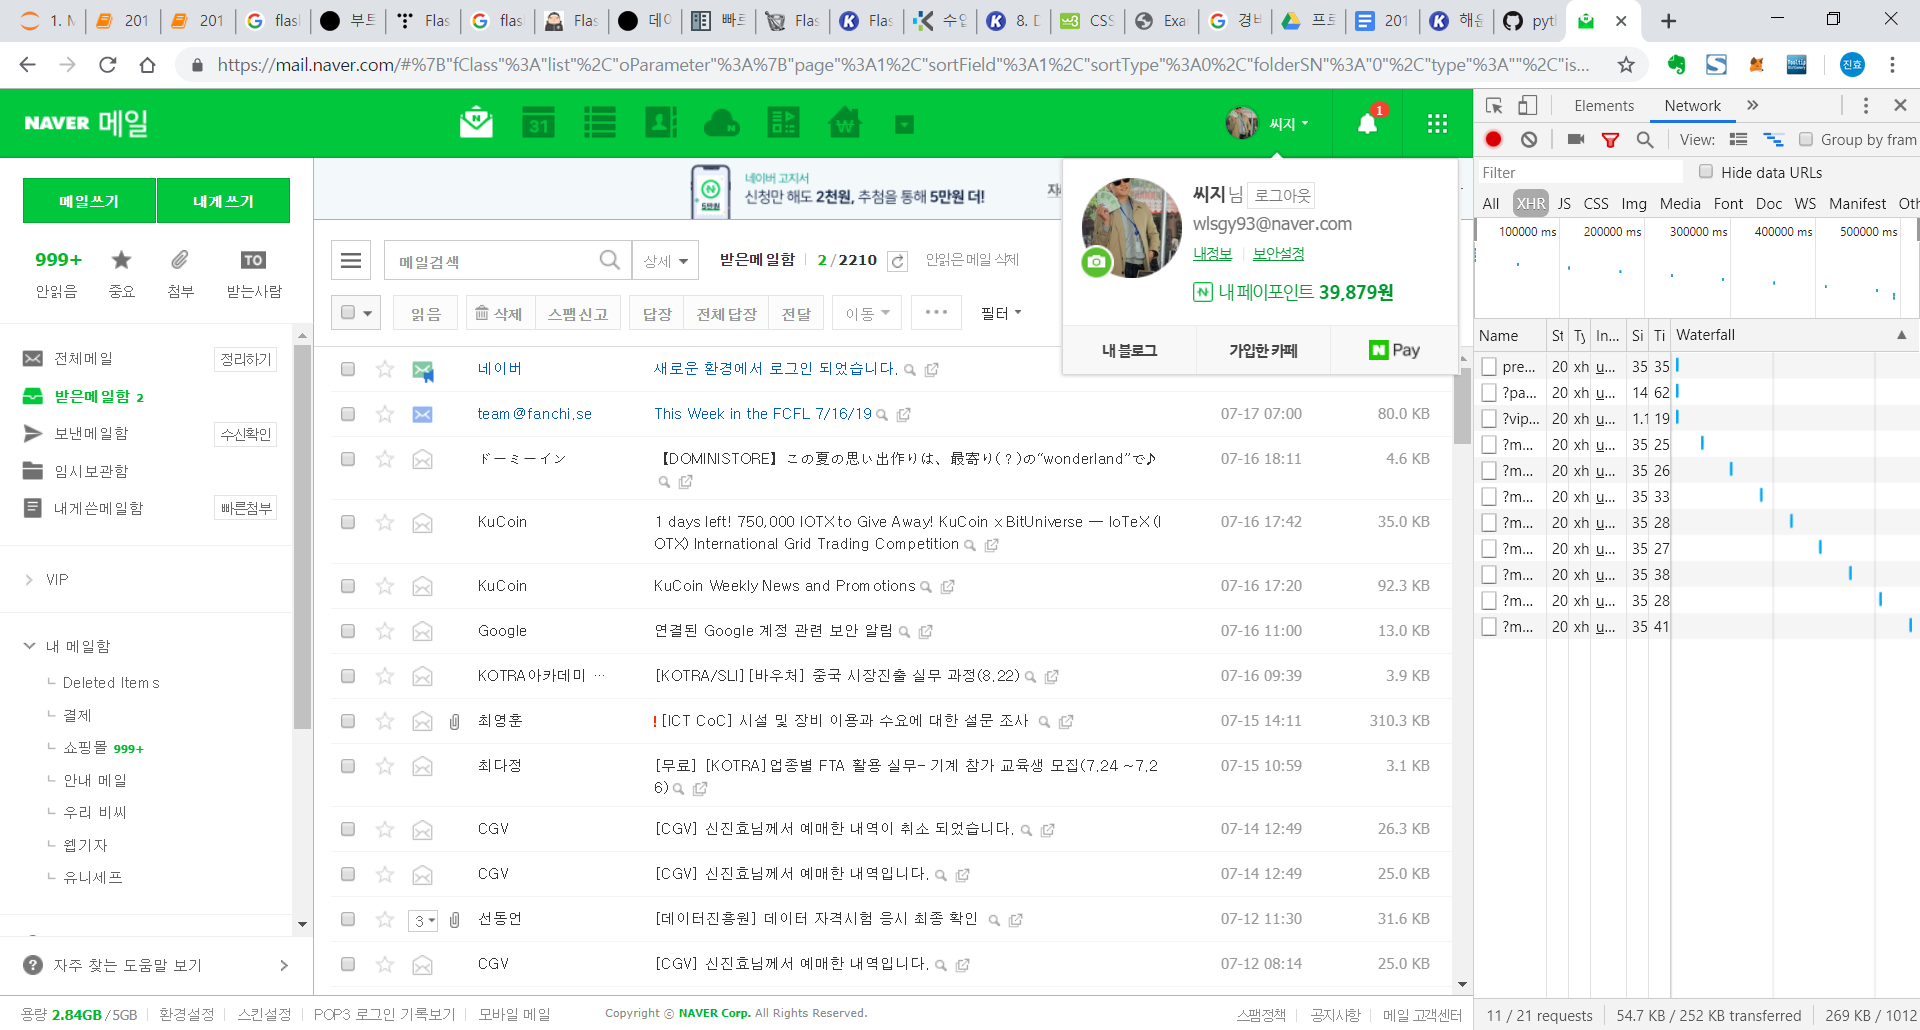

In [289]:
# 에러가 안나는 10초동안에 네이버에 가서 로그아웃 창을 수동으로 띄워줘야함.
# 아까 네이버 메일에서 로그아웃 했던거를 여기서 다시 함.
# 브라우저가 렌더링이 끝날때까지 잠깐 기다려주는 용도 외에 이렇게도 수동으로 뭔가 클릭해줘야하는 상황에서도 활용 가능함.

driver.find_element_by_css_selector("#gnb_name2 + a.gnb_btn_login").click()

In [ ]:
wait = WebDriverWait(driver, 10, 0.5, [ElementNotVisibleException])

# 인자로 넣는 메서드를 lambda로도 할 수 있다.
# is_displayed : 현재 원격 브라우저에 해당하는 부분이 보이는지? 에 대한 True, False 메서드
wait.until(lambda x:x.find_element_by_css_selector("#gnb_name2 + a.gnb_btn_login").is_displayed())

In [284]:
# 아까와 마찬가지로 10초 안에 후딱 프로필을 클릭해서 로그아웃 메뉴가 브라우저에 보이게 해줘야 한다.
driver.find_element_by_css_selector("#gnb_name2 + a.gnb_btn_login")

<selenium.webdriver.remote.webelement.WebElement (session="7a0f53dfcac4639316361b187672bdb2", element="0.9601453095260744-1")>

In [281]:
logout = driver.find_element_by_css_selector("#gnb_name2 + a.gnb_btn_login")

In [285]:
# 브라우저에서 네이버 메일을 띄워놓고 한번 실행해보고,
# 프로필을 클릭해서 로그아웃이 보이게 한 상태에서 실행해보자.

# 창이 보일때는 True.

logout.is_displayed()

False

---

### 네이버 메인에서 광고이미지 가져오기
    - 광고는 iframe이다.
    - html 안의 html이라서 바로 못 가져온다.
    - iframe을 탐색하는 방법을 배워보자

In [309]:
driver.get("https://www.naver.com")

In [310]:
# 우선 소스코드에서 iframe을 찾는다.
iframe = driver.find_element_by_name("da_iframe_time")

# frame 속으로 driver를 전환시키는 메서드
# 이제 driver는 iframe속의 html 소스코드를 보고 있다.
driver.switch_to_frame(iframe)

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: use driver.switch_to.frame instead
  


In [311]:
# 이미지 소스를 가져올 수 있다.

driver.find_element_by_tag_name("img").get_attribute("src")

'https://ssl.pstatic.net/tveta/libs/1242/1242461/931c8cbd4141fa0965c1_20190715175329354.jpg'

In [312]:
# 원래 작업하던 iframe 밖으로 돌아오기
# 기본 html로 돌아옴.

driver.switch_to_default_content()

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.default_content instead
  """Entry point for launching an IPython kernel.


----

### 새창이 띄워졌을때

In [314]:
driver.get("http://www.kt.com")

In [ ]:
# 현재 띄워져 있는 창의 목록을 보여줌.
# 하나만 켜져있다면 1개만 나옴.

driver.window_handles

In [316]:
# 로그인 버튼 클릭
# 로그인용 새 창이 뜬다.

driver.find_element_by_css_selector("span.quick > a").click()

In [317]:
# 새창이 띄워졌으므로, 창 목록이 늘었다.

driver.window_handles

['CDwindow-01E401EE9C92E72818875E96E3BBCA0D',
 'CDwindow-046E16BA0A17D59CACF4C36F8B58C1DA']

In [319]:
# 창을 이동하기
# 이동할 창의 이름을 인자로 전달하면 된다.

driver.switch_to_window(driver.window_handles[1])

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: use driver.switch_to.window instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [321]:
# id 치는 부분에 test라는 문구 입력하기
# 여기까지만 해보면 충분!

driver.find_element_by_id("userId").send_keys("test")

In [325]:
# 다시 원래 창으로 돌아가자.

driver.switch_to_window(driver.window_handles[0])

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.window instead
  """Entry point for launching an IPython kernel.


In [326]:
# 다시 로그인 창으로 돌아가서 창을 닫아주자.

driver.switch_to_window(driver.window_handles[1])

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.window instead
  """Entry point for launching an IPython kernel.


In [327]:
# 현재 창 닫기

driver.close()

In [328]:
# 1개만 남았다.

driver.window_handles

['CDwindow-01E401EE9C92E72818875E96E3BBCA0D']

In [330]:
# 창을 닫고 나서 작업할 창을 선택해줘야한다.

driver.switch_to_window(driver.window_handles[0])

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.window instead
  """Entry point for launching an IPython kernel.


---

### 새창을 띄워보자
    - 새 창을 띄워서 새창에서 뉴스 기사를 열고 스크래핑하게 하자.

In [331]:
# javascript 명령을 통해서 새창을 띄운다.

driver.execute_script("javascript:window.open('about:blank');")

In [334]:
# 선생님 코드

conn = sqlite3.connect("teacher_naver_new3.db")
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS table1;
CREATE TABLE table1(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    title TEXT NOT NULL,
    url TEXT NOT NULL );
    
DROP TABLE IF EXISTS table2;
CREATE TABLE table2(
    id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    table1_id INTEGER NOT NULL,
    content TEXT NOT NULL);
""")
conn.commit()

driver.get("https://news.naver.com")

for _ in [_ for _ in driver.find_elements_by_css_selector(
            ".hdline_news .hdline_article_tit > a, .com_list li > a")
            if len(_.get_attribute("href")) > 1] :
    news = (_.text, _.get_attribute("href"))
    
    cur.execute("INSERT INTO table1(title, url) VALUES(?, ?)", [news[0], news[1]])
    conn.commit()
        
    cur.execute("SELECT id FROM table1 WHERE url=?", [news[1]])
    newsID = cur.fetchone()[0]
    
    driver.execute_script("javascript:window.open('about:blank');")
    driver.switch_to.window(driver.window_handles[-1])
    driver.get(news[1])
    
    cur.execute("INSERT INTO table2(table1_id, content) VALUES(?, ?)", 
                [newsID, driver.find_element_by_css_selector("#articleBodyContents").text])
    conn.commit()
    
    driver.close()
    driver.switch_to.window(driver.window_handles[0])

C:\Users\JINHYO\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: use driver.switch_to.window instead
